In [1]:
import argparse
import os
import copy

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont

# OwlViT Detection
from transformers import OwlViTProcessor, OwlViTForObjectDetection

# segment anything
from segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt

import gc

In [2]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def plot_boxes_to_image(image_pil, tgt):
    H, W = tgt["size"]
    boxes = tgt["boxes"]
    labels = tgt["labels"]
    assert len(boxes) == len(labels), "boxes and labels must have same length"

    draw = ImageDraw.Draw(image_pil)
    mask = Image.new("L", image_pil.size, 0)
    mask_draw = ImageDraw.Draw(mask)

    # draw boxes and masks
    for box, label in zip(boxes, labels):
        # random color
        color = tuple(np.random.randint(0, 255, size=3).tolist())
        # draw
        x0, y0, x1, y1 = box
        x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)

        draw.rectangle([x0, y0, x1, y1], outline=color, width=6)
        draw.text((x0, y0), str(label), fill=color)

        font = ImageFont.load_default()
        if hasattr(font, "getbbox"):
            bbox = draw.textbbox((x0, y0), str(label), font)
        else:
            w, h = draw.textsize(str(label), font)
            bbox = (x0, y0, w + x0, y0 + h)
        # bbox = draw.textbbox((x0, y0), str(label))
        draw.rectangle(bbox, fill=color)
        draw.text((x0, y0), str(label), fill="white")

        mask_draw.rectangle([x0, y0, x1, y1], fill=255, width=6)

    return image_pil, mask

def load_owlvit(checkpoint_path="owlvit-large-patch14", device='cpu'):
    """
    Return: model, processor (for text inputs)
    """
    processor = OwlViTProcessor.from_pretrained(f"google/{checkpoint_path}")
    model = OwlViTForObjectDetection.from_pretrained(f"google/{checkpoint_path}")
    # model.to(device)
    model.eval()
    
    return model, processor


In [12]:
# parser = argparse.ArgumentParser("OWL-ViT Segment Aything", add_help=True)

# parser.add_argument("--image_path", "-i", type=str, required=True, help="path to image file")
# parser.add_argument("--text_prompt", "-t", type=str, required=True, help="text prompt")
# parser.add_argument(
#     "--output_dir", "-o", type=str, default="outputs", required=True, help="output directory"
# )
# parser.add_argument('--owlvit_model', help='select model', default="owlvit-base-patch32", choices=["owlvit-base-patch32", "owlvit-base-patch16", "owlvit-large-patch14"])
# parser.add_argument("--box_threshold", type=float, default=0.0, help="box threshold")
# parser.add_argument('--get_topk', help='detect topk boxes per class or not', action="store_true")
# parser.add_argument('--device', help='select device', default="cuda:0", type=str)
# args = parser.parse_args()

# # cfg
# # checkpoint_path = args.checkpoint_path  # change the path of the model
# image_path = args.image_path
# text_prompt = args.text_prompt
# output_dir = args.output_dir
# box_threshold = args.box_threshold
# if args.get_topk:
#     box_threshold = 0.0

get_topk = True
image_path = "/home/will/workspace/playground/2dbb_3dpc/__pycache__/owl-vit_sam_output/output.png"
text_prompt = "pear,lime,onion,apple,orange"
output_dir = "/home/will/workspace/playground/2dbb_3dpc/__pycache__/owl-vit_sam_output"
box_threshold = 0.0

# make dir
os.makedirs(output_dir, exist_ok=True)
# load image & texts
image = Image.open(image_path).convert("RGB")
texts = [text_prompt.split(",")]

# load OWL-ViT model
model, processor = load_owlvit(checkpoint_path="owlvit-base-patch32", device="cuda:1")


In [13]:
# run object detection model
with torch.no_grad():
    # inputs = processor(text=texts, images=image, return_tensors="pt").to(args.device)
    inputs = processor(text=texts, images=image, return_tensors="pt")
    outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to COCO API
# results = processor.post_process_object_detection(outputs=outputs, threshold=box_threshold, target_sizes=target_sizes.to(args.device))
results = processor.post_process_object_detection(outputs=outputs, threshold=box_threshold, target_sizes=target_sizes)
scores = torch.sigmoid(outputs.logits)
topk_scores, topk_idxs = torch.topk(scores, k=1, dim=1)

i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
if get_topk:    
    topk_idxs = topk_idxs.squeeze(1).tolist()
    topk_boxes = results[i]['boxes'][topk_idxs]
    topk_scores = topk_scores.view(len(text), -1)
    topk_labels = results[i]["labels"][topk_idxs]
    boxes, scores, labels = topk_boxes, topk_scores, topk_labels
else:
    boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]


# Print detected objects and rescaled box coordinates
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

Detected pear with confidence 0.016 at location [369.13, 156.57, 458.23, 232.87]
Detected pear with confidence 0.008 at location [356.6, 89.96, 446.73, 153.39]
Detected onion with confidence 0.024 at location [279.4, 121.14, 344.59, 187.19]
Detected apple with confidence 0.016 at location [286.98, 184.67, 365.35, 246.97]
Detected orange with confidence 0.013 at location [450.99, 235.57, 506.03, 286.75]


In [14]:
boxes

tensor([[369.1339, 156.5683, 458.2322, 232.8673],
        [356.5950,  89.9573, 446.7264, 153.3925],
        [279.3994, 121.1375, 344.5906, 187.1930],
        [286.9793, 184.6661, 365.3535, 246.9739],
        [450.9949, 235.5747, 506.0259, 286.7473]])

In [ ]:
predictor = SamPredictor(build_sam(checkpoint="/home/will/workspace/owlvit_segment_anything/sam_vit_h_4b8939.pth"))


In [15]:
boxes = boxes.cpu().detach().numpy()
normalized_boxes = copy.deepcopy(boxes)

# # visualize pred
size = image.size
pred_dict = {
    "boxes": normalized_boxes,
    "size": [size[1], size[0]], # H, W
    "labels": [text[idx] for idx in labels]
}

# release the OWL-ViT
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

# run segment anything (SAM)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)




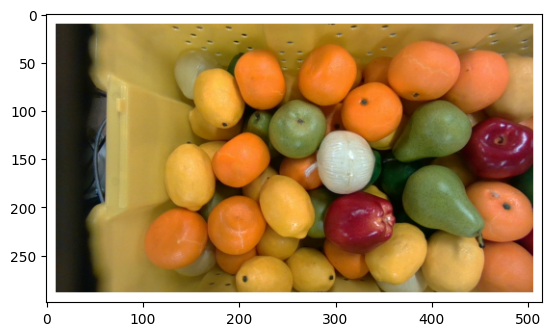

In [16]:
plt.imshow(image)

In [29]:
H, W = size[1], size[0]

for i in range(boxes.shape[0]):
    boxes[i] = torch.Tensor(boxes[i])

boxes = torch.tensor(boxes, device=predictor.device)

transformed_boxes = predictor.transform.apply_boxes_torch(boxes, image.shape[:2])

masks, _, _ = predictor.predict_torch(
    point_coords = None,
    point_labels = None,
    boxes = transformed_boxes,
    multimask_output = False,
)

/tmp/ipykernel_3201/2384145349.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes = torch.tensor(boxes, device=predictor.device)


In [31]:
H, W

(299, 515)

In [30]:
boxes

tensor([[369.1339, 156.5683, 458.2322, 232.8673],
        [356.5950,  89.9573, 446.7264, 153.3925],
        [279.3994, 121.1375, 344.5906, 187.1930],
        [286.9793, 184.6661, 365.3535, 246.9739],
        [450.9949, 235.5747, 506.0259, 286.7473]])

In [32]:
transformed_boxes

tensor([[ 733.9673,  311.5657,  911.1257,  463.3982],
        [ 709.0355,  179.0120,  888.2483,  305.2460],
        [ 555.5437,  241.0595,  685.1665,  372.5077],
        [ 570.6151,  367.4793,  726.4506,  491.4698],
        [ 896.7355,  468.7858, 1006.1564,  570.6176]])

(-0.5, 514.5, 298.5, -0.5)

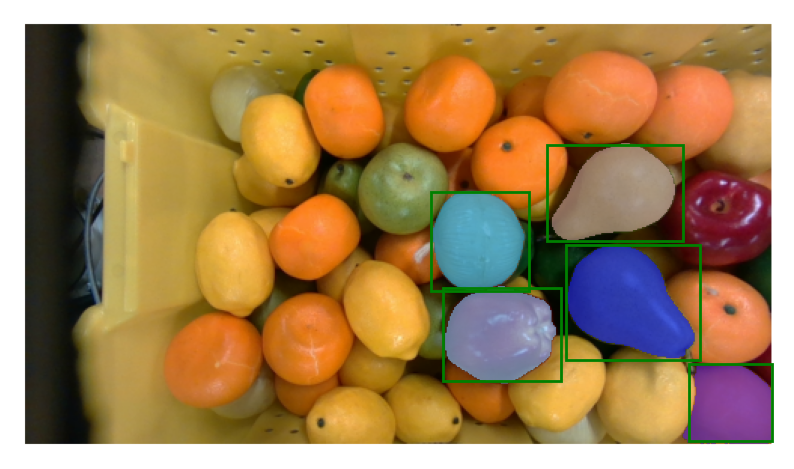

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in boxes:
    show_box(box.numpy(), plt.gca())
plt.axis('off')



In [34]:
normalized_boxes

array([[369.13394, 156.5683 , 458.23218, 232.86734],
       [356.595  ,  89.95729, 446.72644, 153.39252],
       [279.3994 , 121.13746, 344.59058, 187.19296],
       [286.97928, 184.66609, 365.35355, 246.97389],
       [450.99487, 235.5747 , 506.02594, 286.7473 ]], dtype=float32)

In [35]:
boxes

tensor([[369.1339, 156.5683, 458.2322, 232.8673],
        [356.5950,  89.9573, 446.7264, 153.3925],
        [279.3994, 121.1375, 344.5906, 187.1930],
        [286.9793, 184.6661, 365.3535, 246.9739],
        [450.9949, 235.5747, 506.0259, 286.7473]])

In [24]:
# grounded results
image_pil = Image.open(image_path)
image_with_box = plot_boxes_to_image(image_pil, pred_dict)[0]
image_with_box.show()
# image_with_box.save(os.path.join(f"./{output_dir}/owlvit_box.jpg"))